# Corrective RAG

Self-reflection can enhance RAG, enabling correction of poor quality retrieval
or generations.

Several recent papers focus on this theme, but implementing the ideas can be
tricky.

Here we show how to implement self-reflective RAG using `Mistral` and
`LangGraph`.

We'll focus on ideas from one paper, `Corrective RAG (CRAG)`
[here](https://arxiv.org/pdf/2401.15884.pdf).

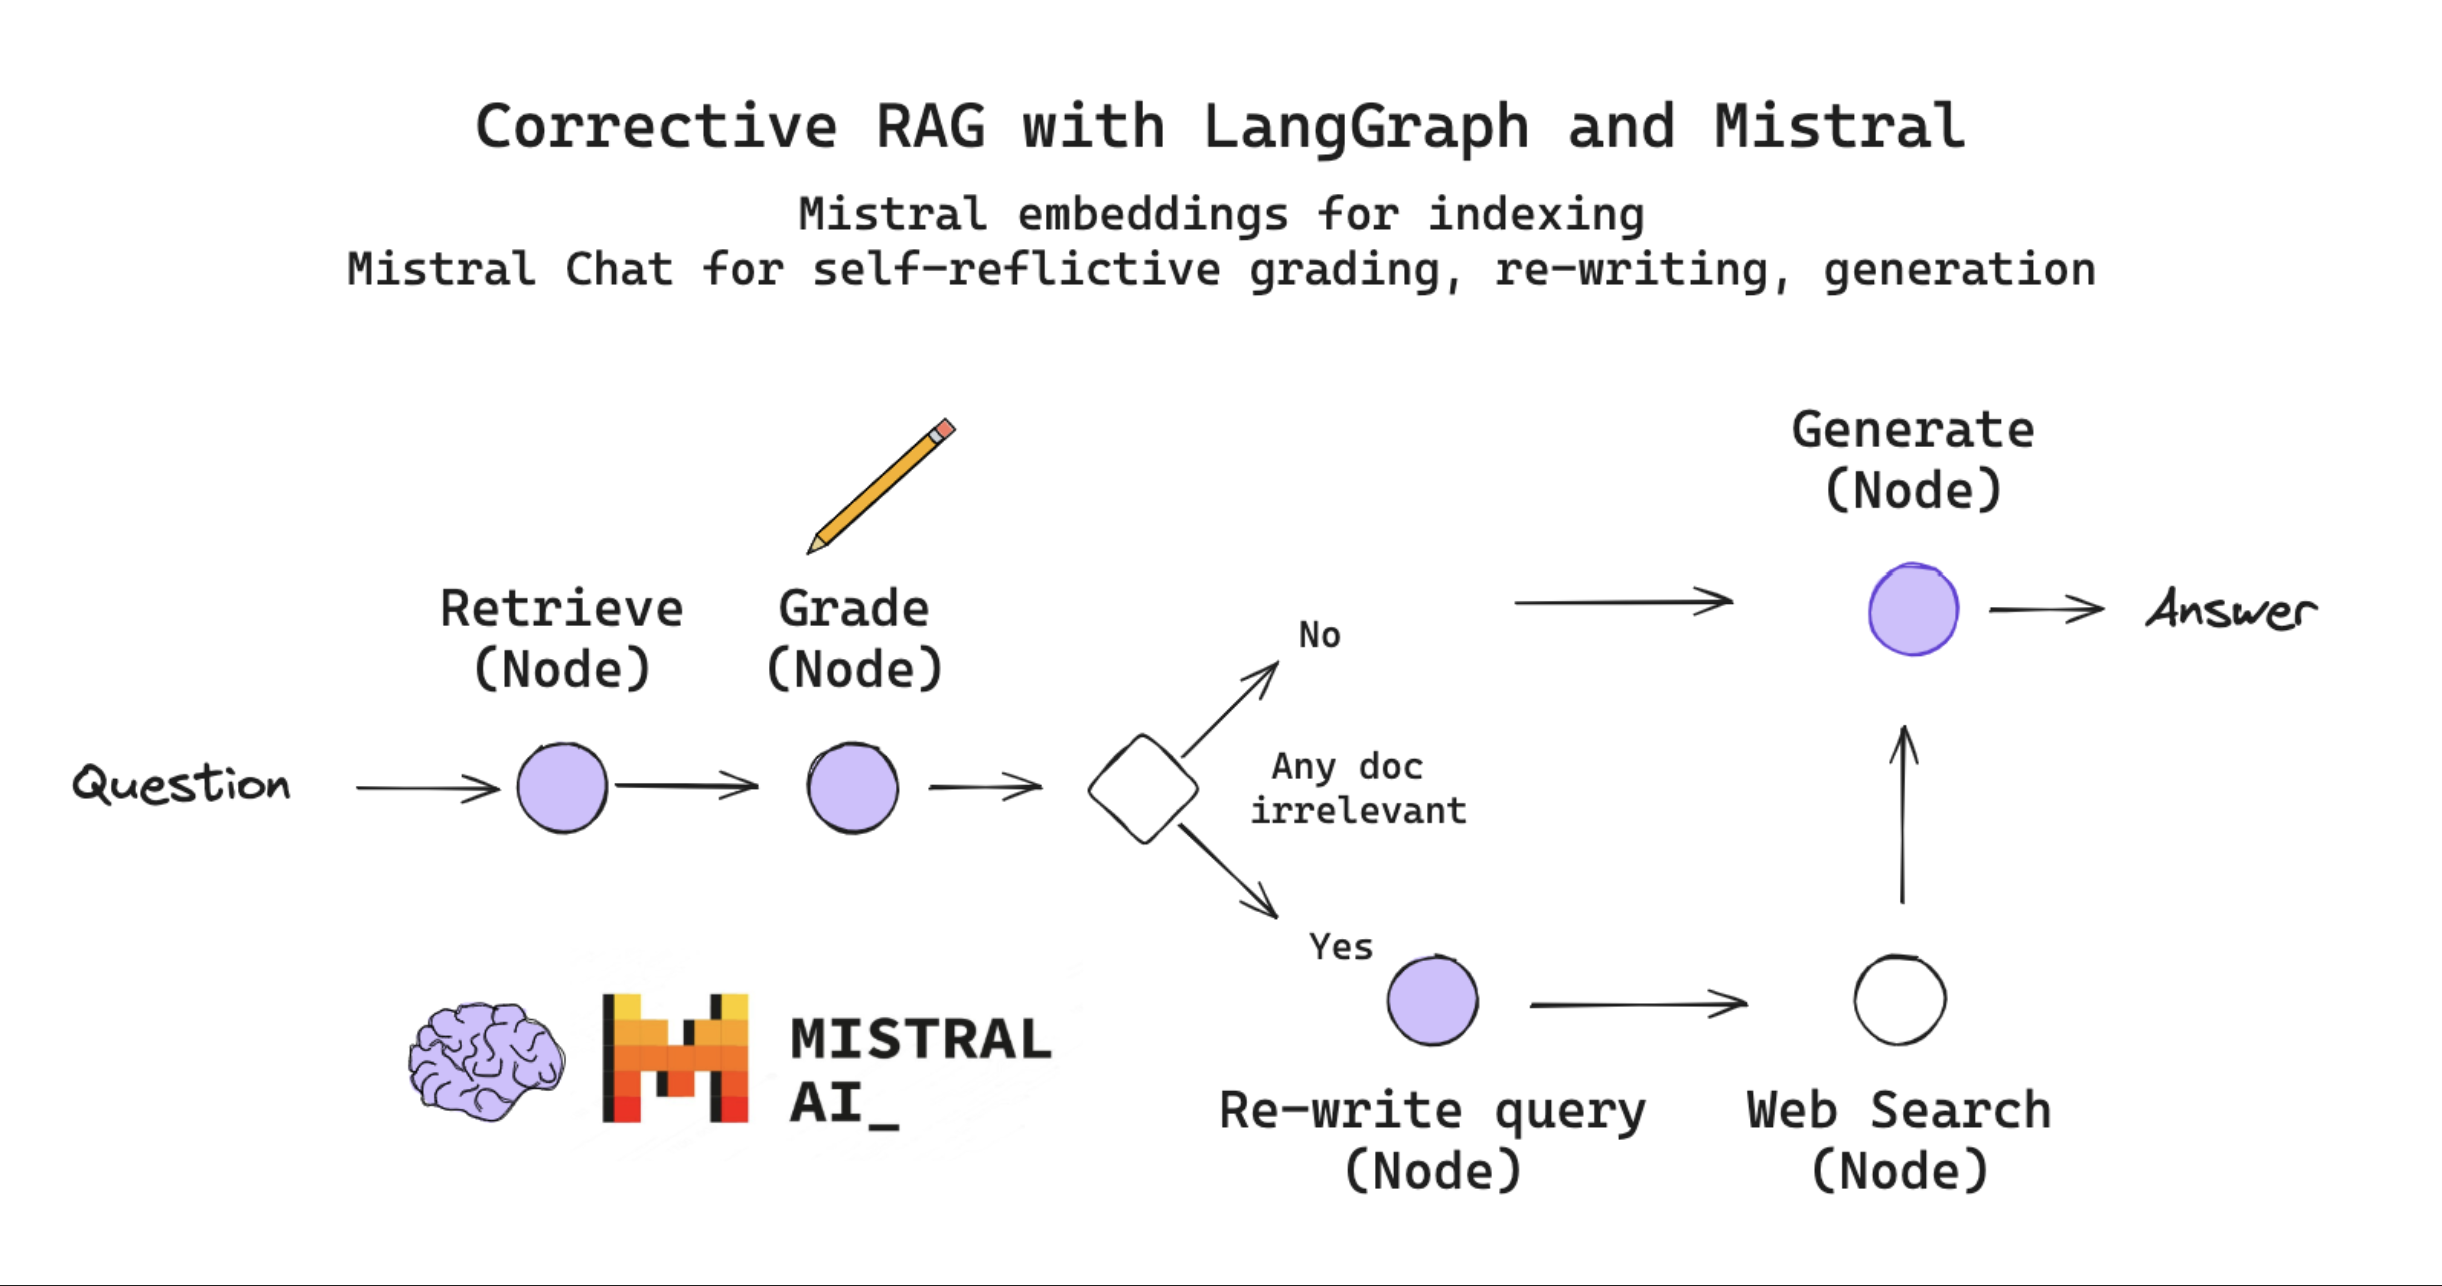

### Running Locally

If you want to run this locally (e.g., on your laptop), use
[Ollama](https://ollama.ai/library/mistral/tags):

- Download [Ollama app](https://ollama.ai/).
- Download a `Mistral` model e.g., `ollama pull mistral:7b-instruct`, from
  various Mistral versions [here](https://ollama.ai/library/mistral) and Mixtral
  versions [here](https://ollama.ai/library/mixtral) available.
- Download LLaMA2 `ollama pull llama2:latest` to use Ollama embeddings.
- Set flags indicating we will run locally and the Mistral model downloaded:

```typescript
const runLocal = true;
const localLlm = "mistral";
```

## Setup

### Load env vars

Add a `.env` variable in the root of the repo with your variables.

- Set `TOGETHER_AI_API_KEY` (optional if you don't want to run the chat model
  locally via Ollama). You can create an account
  [here](https://www.together.ai/).
- Set `MISTRAL_API_KEY` (optional if you don't want to run embeddings locally
  via Ollama) for Mistral AI embeddings.
- Set `TAVILY_API_KEY` to enable web search
  [here](https://app.tavily.com/sign-in).

In [1]:
import "dotenv/config";

[Module: null prototype] { default: {} }

### Install dependencies

```bash
npm install cheerio zod zod-to-json-schema langchain @langchain/community @langchain/core
```

### Tracing

- Optionally, use [LangSmith](https://docs.smith.langchain.com/) for tracing
  (shown at bottom) by setting:

```bash
export LANGCHAIN_TRACING_V2=true
export LANGCHAIN_ENDPOINT=https://api.smith.langchain.com
export LANGCHAIN_API_KEY=<your-api-key>
```

In [2]:
const runLocal = true;
const localLlm = "mistral";

## Indexing

First, let's index a popular blog post on agents.

We can use
[Mistral embeddings](https://js.langchain.com/docs/integrations/text_embedding/mistralai).

For local embeddings, we can use
[Ollama](https://js.langchain.com/docs/integrations/text_embedding/ollama).
You'll need to run `ollama pull nomic-embed-text` to pull the embeddings model
locally.

We'll use a local demo vectorstore, but you can swap in
[your preferred production-ready choice](https://js.langchain.com/docs/integrations/vectorstores).

In [3]:
import "cheerio";
import { CheerioWebBaseLoader } from "langchain/document_loaders/web/cheerio";
import { RecursiveCharacterTextSplitter } from "langchain/text_splitter";
import { OllamaEmbeddings } from "@langchain/community/embeddings/ollama";
import { MemoryVectorStore } from "langchain/vectorstores/memory";
import { MistralAIEmbeddings } from "@langchain/mistralai";

const url = "https://lilianweng.github.io/posts/2023-06-23-agent/";
const loader = new CheerioWebBaseLoader(url);
const docs = await loader.load();

const textSplitter = new RecursiveCharacterTextSplitter({
  chunkSize: 500,
  chunkOverlap: 100,
});
const docSplits = await textSplitter.splitDocuments(docs);

let embeddings;

if (runLocal) {
  embeddings = new OllamaEmbeddings({ model: "nomic-embed-text" });
} else {
  embeddings = new MistralAIEmbeddings();
}

// Add to vectorDB
const vectorStore = await MemoryVectorStore.fromDocuments(
  docSplits,
  embeddings,
);
const retriever = vectorStore.asRetriever();

OllamaEmbeddings {
  caller: AsyncCaller {
    maxConcurrency: 1,
    maxRetries: 6,
    onFailedAttempt: [Function: defaultFailedAttemptHandler],
    queue: PQueue {
      _events: Events <[Object: null prototype] {}> {},
      _eventsCount: 0,
      _intervalCount: 1,
      _intervalEnd: 0,
      _pendingCount: 0,
      _resolveEmpty: [Function: empty],
      _resolveIdle: [Function: empty],
      _carryoverConcurrencyCount: false,
      _isIntervalIgnored: true,
      _intervalCap: Infinity,
      _interval: 0,
      _queue: PriorityQueue { _queue: [] },
      _queueClass: [class PriorityQueue],
      _concurrency: 1,
      _intervalId: undefined,
      _timeout: undefined,
      _throwOnTimeout: false,
      _isPaused: false
    }
  },
  model: "nomic-embed-text",
  baseUrl: "http://localhost:11434",
  headers: undefined,
  keepAlive: "5m",
  requestOptions: undefined
}

## Corrective RAG

Let's implement self-reflective RAG with some ideas from the CRAG (Corrective
RAG) [paper](https://arxiv.org/pdf/2401.15884.pdf):

- Grade documents for relevance relative to the question.
- If any are irrelevant, then we will supplement the context used for generation
  with web search.
- For web search, we will re-phrase the question and use Tavily API.
- We will then pass retrieved documents and web results to an LLM for final
  answer generation.

Here is a schematic of our graph in more detail:

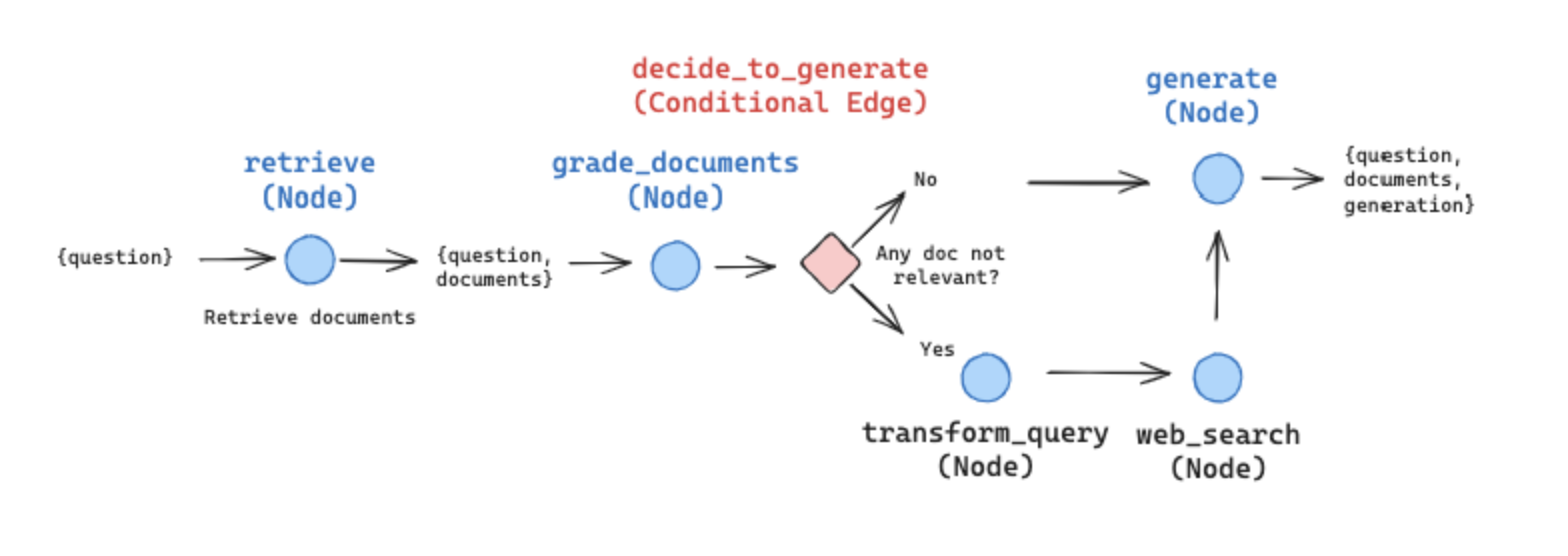

We will implement this using
[LangGraph](https://js.langchain.com/docs/langgraph):

- See video
  [here](https://www.youtube.com/watch?ref=blog.langchain.dev&v=pbAd8O1Lvm4&feature=youtu.be)
- See blog post [here](https://blog.langchain.dev/agentic-rag-with-langgraph/)

---

### State

Every node in our graph will modify `state`, which is dict that contains values
(`question`, `documents`, etc) relevant to RAG.

In [4]:
/**
 * Represents the state of our graph.
 */
type GraphState = {
  /**
   * An object where each key is a string.
   */
  keys: Record<string, any>;
};

const graphState = {
  keys: {
    value: null,
    default: () => ({}),
  },
};

### Nodes and Edges

Every node in the graph we laid out above is a function.

Each node will modify the state in some way.

Each edge will choose which node to call next.

In [ ]:
import { TavilySearch } from "@langchain/tavily";
import { Document, DocumentInterface } from "@langchain/core/documents";
import { z } from "zod";
import { ChatPromptTemplate } from "@langchain/core/prompts";
import { pull } from "langchain/hub";
import { StringOutputParser } from "@langchain/core/output_parsers";
import { ChatOllama } from "@langchain/community/chat_models/ollama";
import { ChatTogetherAI } from "@langchain/community/chat_models/togetherai";
import { BaseMessageChunk } from "@langchain/core/messages";
import { zodToJsonSchema } from "zod-to-json-schema";
import type { RunnableConfig } from "@langchain/core/runnables";

/**
 * Retrieve documents
 *
 * @param {GraphState} state The current state of the graph.
 * @param {RunnableConfig | undefined} config The configuration object for tracing.
 * @returns {Promise<GraphState>} The new state object.
 */
async function retrieve(state: GraphState, config?: RunnableConfig) {
  console.log("---RETRIEVE---");
  const stateObject = state.keys;
  const question = stateObject.question;
  const documents = await retriever.invoke(question, config);
  return {
    keys: {
      ...stateObject,
      documents,
      question,
    },
  };
}

/**
 * Generate answer
 *
 * @param {GraphState} state The current state of the graph.
 * @param {RunnableConfig | undefined} config The configuration object for tracing.
 * @returns {Promise<GraphState>} The new state object.
 */
async function generate(state: GraphState) {
  console.log("---GENERATE---");
  const stateObject = state.keys;
  const documents = stateObject.documents;
  const question = stateObject.question;
  const local = stateObject.local;

  // Pull in the prompt
  const prompt = await pull<ChatPromptTemplate>("rlm/rag-prompt");

  let llm;
  if (local) {
    llm = new ChatOllama({ model: localLlm, temperature: 0 });
  } else {
    llm = new ChatTogetherAI({
      modelName: "mistralai/Mixtral-8x7B-Instruct-v0.1",
      temperature: 0,
    });
  }

  // RAG Chain
  const ragChain = prompt.pipe(llm).pipe(new StringOutputParser());

  const formattedDocs = documents.map((doc) => doc.pageContent).join("\n\n");

  const generation = await ragChain.invoke({
    context: formattedDocs,
    question,
  });

  return {
    keys: {
      ...stateObject,
      generation,
    },
  };
}

/**
 * Determines whether the retrieved documents are relevant to the question.
 *
 * @param {GraphState} state The current state of the graph.
 * @param {RunnableConfig | undefined} config The configuration object for tracing.
 * @returns {Promise<GraphState>} The new state object.
 */
async function gradeDocuments(state: GraphState) {
  console.log("---CHECK RELEVANCE---");
  const stateObject = state.keys;
  const documents = stateObject.documents;
  const question = stateObject.question;
  const local = stateObject.local;

  let llm;
  if (local) {
    llm = new ChatOllama({
      model: localLlm,
      temperature: 0,
      format: "json",
    });
  } else {
    const zodScore = z.object({
      binaryScore: z.enum(["yes", "no"]).describe(
        "Relevance score 'yes' or 'no'",
      ),
    });
    llm = new ChatTogetherAI({
      modelName: "mistralai/Mixtral-8x7B-Instruct-v0.1",
      temperature: 0,
    }).bind({
      response_format: {
        type: "json_object",
        schema: zodToJsonSchema(zodScore),
      },
    });
  }

  const prompt = ChatPromptTemplate.fromTemplate(
    `You are a grader assessing relevance of a retrieved document to a user question. \n 
  Here is the retrieved document: \n\n {context} \n\n
  Here is the user question: {question} \n
  If the document contains keywords related to the user question, grade it as relevant. \n
  It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
  Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
  Use the 'grade' tool to provide the score.
  Instructions: {formatInstructions}`,
  );

  const formatInstructions =
    "Respond with a valid JSON object containing a single key 'binaryScore' with a value of 'yes' or 'no'.";

  const filteredDocs: Array<DocumentInterface> = [];
  let runWebSearch = "No";
  for await (const doc of documents) {
    let finalRes = "";

    // Ollama JSON mode has a bug (as of 02/15/2024) where it logs infinite tab unicode characters.
    // To hack around this, we attach a stop signal to the LLM, and if the last character in the
    // response returns '9' from .charCodeAt() we know it has started logging infinite tab unicode characters.
    try {
      const controller = new AbortController();
      // Chain
      const chain = prompt.pipe(llm.bind({ signal: controller.signal }));
      const stream = await chain.stream({
        context: doc.pageContent,
        question,
        formatInstructions,
      });
      for await (const item of stream) {
        finalRes += (item as BaseMessageChunk).content;
        const prevCharCodeAt = finalRes.length > 1 &&
          finalRes.charCodeAt(finalRes.length - 2);
        const charCodeAt = finalRes.charCodeAt(finalRes.length - 1);
        if (prevCharCodeAt === 9 && charCodeAt === 9) {
          controller.abort();
        }
      }
    } catch (e) {
      // no-op
      console.log("Infinite tab response detected. Aborting.");
    }

    const parsed = JSON.parse(finalRes.trim());
    if (parsed.binaryScore === "yes") {
      console.log("---GRADE: DOCUMENT RELEVANT---");
      filteredDocs.push(doc);
    } else {
      runWebSearch = "Yes";
      console.log("---GRADE: DOCUMENT NOT RELEVANT---");
    }
  }

  return {
    keys: {
      ...stateObject,
      documents: filteredDocs,
      runWebSearch,
    },
  };
}

/**
 * Transform the query to produce a better question.
 *
 * @param {GraphState} state The current state of the graph.
 * @param {RunnableConfig | undefined} config The configuration object for tracing.
 * @returns {Promise<GraphState>} The new state object.
 */
async function transformQuery(state: GraphState) {
  console.log("---TRANSFORM QUERY---");
  const stateObject = state.keys;
  const question = stateObject.question;
  const local = stateObject.local;

  // Pull in the prompt
  const prompt = ChatPromptTemplate.fromTemplate(
    `You are generating questions that is well optimized for semantic search retrieval. \n 
  Look at the input and try to reason about the underlying sematic intent / meaning. \n 
  Here is the initial question:
  \n ------- \n
  {question} 
  \n ------- \n
  Provide an improved question without any preamble, only respond with the updated question: `,
  );

  // Grader
  let llm;
  if (local) {
    llm = new ChatOllama({ model: localLlm, temperature: 0 });
  } else {
    llm = new ChatTogetherAI({
      modelName: "mistralai/Mixtral-8x7B-Instruct-v0.1",
      temperature: 0,
    });
  }

  // Prompt
  const chain = prompt.pipe(llm).pipe(new StringOutputParser());
  const betterQuestion = await chain.invoke({ question });

  return {
    keys: {
      ...stateObject,
      question: betterQuestion,
    },
  };
}

/**
 * Web search based on the re-phrased question using Tavily API.
 *
 * @param {GraphState} state The current state of the graph.
 * @param {RunnableConfig | undefined} config The configuration object for tracing.
 * @returns {Promise<GraphState>} The new state object.
 */
async function webSearch(state: GraphState) {
  console.log("---WEB SEARCH---");
  const stateObject = state.keys;
  const question = stateObject.question;
  const documents = stateObject.documents;

  const tool = new TavilySearch();
  const docs = await tool.invoke(question);
  const webResults = new Document({ pageContent: docs });
  const newDocs = documents.concat(webResults);

  return {
    keys: {
      ...stateObject,
      documents: newDocs,
    },
  };
}

/**
 * Determines whether to generate an answer or re-generate a question for web search.
 *
 * @param {GraphState} state The current state of the graph.
 * @returns {Promise<GraphState>} The new state object.
 */
function decideToGenerate(state: GraphState) {
  console.log("---DECIDE TO GENERATE---");
  const stateObject = state.keys;
  const search = stateObject.runWebSearch;

  if (search === "Yes") {
    // All documents have been filtered checkRelevance
    // We will re-generate a new query
    console.log("---DECISION: TRANSFORM QUERY and RUN WEB SEARCH---");
    return "transformQuery";
  }
  // We have relevant documents, so generate answer
  console.log("---DECISION: GENERATE---");
  return "generate";
}

## Build Graph

The just follows the flow we outlined in the figure above.

In [6]:
import { END, START, StateGraph } from "@langchain/langgraph";

const workflow = new StateGraph<GraphState>({
  channels: graphState,
});

// Define the nodes
workflow.addNode("retrieve", retrieve);
workflow.addNode("gradeDocuments", gradeDocuments);
workflow.addNode("generate", generate);
workflow.addNode("transformQuery", transformQuery);
workflow.addNode("webSearch", webSearch);

// Build graph
workflow.addEdge(START, "retrieve");
workflow.addEdge("retrieve", "gradeDocuments");
workflow.addConditionalEdges(
  "gradeDocuments",
  decideToGenerate,
  {
    transformQuery: "transformQuery",
    generate: "generate",
  },
);
workflow.addEdge("transformQuery", "webSearch");
workflow.addEdge("webSearch", "generate");
workflow.addEdge("generate", END);

// Compile
const app = workflow.compile();

## Run

In [7]:
const inputs = {
  keys: {
    question: "Explain how the different types of agent memory work.",
    local: runLocal,
  },
};
const config = { recursionLimit: 50 };
let finalGeneration;
for await (const output of await app.stream(inputs, config)) {
  for (const [key, value] of Object.entries(output)) {
    console.log(`Node: '${key}'`);
    // Optional: log full state at each node
    // console.log(JSON.stringify(value, null, 2));
    finalGeneration = value;
  }
  console.log("\n---\n");
}

// Log the final generation.
console.log(JSON.stringify(finalGeneration, null, 2));

---RETRIEVE---
Node: 'retrieve'

---

---CHECK RELEVANCE---
Infinite tab response detected. Aborting.
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
Node: 'gradeDocuments'

---

---DECIDE TO GENERATE---
---DECISION: TRANSFORM QUERY and RUN WEB SEARCH---
---TRANSFORM QUERY---
Node: 'transformQuery'

---

---WEB SEARCH---
Node: 'webSearch'

---

---GENERATE---
Node: 'generate'

---

Node: '__end__'

---

{
  "keys": {
    "question": " What are the functions and workings of different types of agent memory?",
    "local": true,
    "documents": [
      {
        "pageContent": "Agent System Overview\n                \n                    Component One: Planning\n                        \n                \n                    Task Decomposition\n                \n                    Self-Reflection\n                \n                \n                    Component Two: Memory\n                        \n       

> #### See the LangSmith trace [here](https://smith.langchain.com/public/a289cd5f-507f-4f03-9bfc-d1ef6281c080/r).